# Lunarlander-V3

Projektet kommer att göras i en notebook då det är enklare att presentera projektets olika delar. Projektet kommer att se på Lunarlander-v3 och modellerna PPO och DQN, där jag kommer jämföra resultaten av hur agenten presterat.
Vi börjar med alla importer, sedan tar vi DQN först och därefter PPO. Vi använder oss av lunarlander-v3 miljön i sin enklaste form, utan extra vind eller gravitation.



In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import optuna

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy
from stable_baselines3.ppo import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

c:\Users\irisf\Arcada25\PresA25\lunlarlander-pres-a-25\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Denna kod är tagen från cart-pole uppgiften (6), vilken hjälper oss att vislualisera vår träning. 

In [13]:
def plot_learning_curve(log_path, window_size=100):
    """Generates and saves a plot of the learning curve."""
    try:
        log_data = pd.read_csv(log_path + ".monitor.csv", skiprows=1)
        cumulative_timesteps = log_data['l'].cumsum()
        moving_avg = log_data['r'].rolling(window=window_size, min_periods=1).mean()
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_timesteps, log_data['r'], alpha=0.3, label='Per-Episode Reward')
        plt.plot(cumulative_timesteps, moving_avg, color='red', linewidth=2, label=f'Moving Average (window={window_size})')
        plt.title("Learning Curve of the Final Agent")
        plt.xlabel("Timesteps")
        plt.ylabel("Episode Reward")
        plt.legend()
        plt.grid(True)
        plt.savefig("learning_curve.png")
        print("\nLearning curve plot saved to learning_curve.png")
    except FileNotFoundError:
        print("\nCould not find monitor log file. Skipping learning curve plot.")

In [4]:
LOG_DIR = "logs/"
os.makedirs(LOG_DIR, exist_ok=True)

# DQN

In [12]:
# Vi använder oss av två miljöer, en för traning och en för evaluation.
train_env = gym.make('LunarLander-v3')
monitor_file = os.path.join(LOG_DIR, "lunar_train")
train_env = Monitor(train_env, monitor_file)

eval_env = gym.make("LunarLander-v3")
eval_monitor = os.path.join(LOG_DIR, "lunar_eval")
eval_env = Monitor(eval_env, eval_monitor)

# Dessa hyperparamterar hittades på nätet samt tog hjälp av AI
policy_kwargs = dict(net_arch=[256, 256])
model = DQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=6.3e-4,
    batch_size=128,
    buffer_size=100000,
    learning_starts=0,
    gamma=0.99,
    target_update_interval=1000,
    train_freq=4,
    gradient_steps=-1,
    exploration_fraction=0.3,
    exploration_final_eps=0.05,
    policy_kwargs=policy_kwargs, # använd ett större nätverk
    verbose=0
)

# Träna agenten
model.learn(total_timesteps=int(5e5))
model.save("dqn_lunarlander")

# Simulera och testa modellen
average_reward = 0   
num_episodes = 500
total_rewards = []
n_count = 0

for episode in range(num_episodes):
    state, _ = eval_env.reset()
    episode_reward = 0
    done = False
    truncated = False
    n_count += 1

    while not done:
        action, _states = model.predict(state, deterministic=True)
        state, reward, done, truncated, info = eval_env.step(action)
        episode_reward += reward
        if done or truncated:
            break

   # print(f"Episode {n_count}: reward {episode_reward}")
    total_rewards.append(episode_reward)

    if (episode + 1) % 10 == 0:
      print(f"Episode {n_count}: reward {episode_reward}")

# Evaluera agenten  
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"Mean reward after training: {mean_reward:.2f} +/- {std_reward:.2f}")

# Stäng miljöerna
eval_env.close()
train_env.close()

Episode 10: reward 284.664211162788
Episode 20: reward 300.7484583409396
Episode 30: reward 251.13211502080944
Episode 40: reward 274.1373740435394
Episode 50: reward 266.6712782028477
Episode 60: reward 311.3200734095025
Episode 70: reward 246.3937618479627
Episode 80: reward 273.0060067300787
Episode 90: reward 296.4810051863417
Episode 100: reward 292.21522611532737
Episode 110: reward 297.150060661514
Episode 120: reward 287.5725133936803
Episode 130: reward 245.74722785277024
Episode 140: reward 295.26163114437304
Episode 150: reward 294.13233311661736
Episode 160: reward 299.769515005347
Episode 170: reward 281.6802003542544
Episode 180: reward -308.0988759998454
Episode 190: reward 303.8764871939227
Episode 200: reward 238.96106436356564
Episode 210: reward 281.66763400220236
Episode 220: reward 249.89581169885338
Episode 230: reward 306.7077354765795
Episode 240: reward 305.01373339753866
Episode 250: reward 281.97066435087515
Episode 260: reward 274.2004459403615
Episode 270: 

#### Visualisera träningen


Learning curve plot saved to learning_curve.png


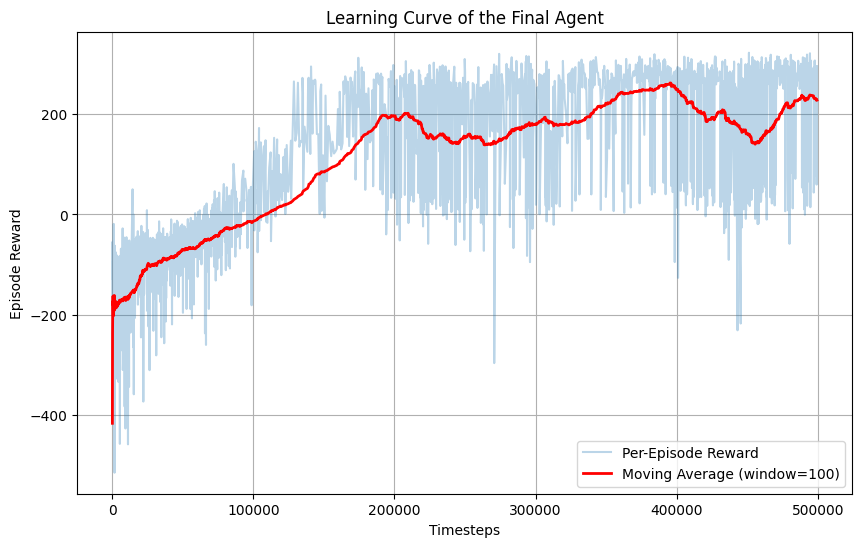

In [13]:
plot_learning_curve(monitor_file) 
#23min träning 
# Mean reward after training: 282.30 +/- 28.12


# PPO

In [14]:
train_env2 = gym.make('LunarLander-v3')
monitor_file2 = os.path.join(LOG_DIR, "lunar_train2")
train_env2 = Monitor(train_env2, monitor_file2)

eval_env2 = gym.make("LunarLander-v3")
eval_monitor2 = os.path.join(LOG_DIR, "lunar_eval2")
eval_env2 = Monitor(eval_env2, eval_monitor2)

policy_kwargs = dict(net_arch=[256, 256])

model2 = PPO(
  policy='MlpPolicy',
  env =train_env2,
  n_steps=2048,
  batch_size=64,
  gae_lambda=0.95,
  gamma=0.99,
  n_epochs=10,
  ent_coef=0.0,
  policy_kwargs=policy_kwargs, # använd ett större nätverk
  learning_rate=3e-4,
  clip_range=0.2,
  verbose=0
)

model2.learn(total_timesteps=int(5e5))
model2.save("ppo_lunarlander")

# Simulera och testa modellen
average_reward = 0   
num_episodes = 500
total_rewards = []
n_count = 0

for episode in range(num_episodes):
    state, _ = eval_env2.reset()
    episode_reward = 0
    done = False
    truncated = False
    n_count += 1

    while not done:
        action, _states = model2.predict(state, deterministic=True)
        state, reward, done, truncated, info = eval_env2.step(action)
        episode_reward += reward
        if done or truncated:
            break

   # print(f"Episode {n_count}: reward {episode_reward}")
    total_rewards.append(episode_reward)

    if (episode + 1) % 10 == 0:
      print(f"Episode {n_count}: reward {episode_reward}")

# Evaluate the agent    
mean_reward2, std_reward2 = evaluate_policy(model2, eval_env2, n_eval_episodes=10)
print(f"Mean reward after training: {mean_reward2:.2f} +/- {std_reward2:.2f}")


eval_env2.close()
train_env2.close()

Episode 10: reward 156.87852902889142
Episode 20: reward 224.81730239364566
Episode 30: reward 223.19262322179958
Episode 40: reward 221.92852983047845
Episode 50: reward 231.51853791996479
Episode 60: reward 206.1702551810563
Episode 70: reward 223.39588569920693
Episode 80: reward 258.5566113401206
Episode 90: reward 8.5047653181783
Episode 100: reward 183.06913233715977
Episode 110: reward 235.4013383170002
Episode 120: reward -261.13546934050964
Episode 130: reward 3.256222976557723
Episode 140: reward 244.99398795446592
Episode 150: reward -2.383871899072929
Episode 160: reward 245.44685023732993
Episode 170: reward 212.83829661913566
Episode 180: reward 213.77149079772835
Episode 190: reward 190.7725862902289
Episode 200: reward 266.32178014596957
Episode 210: reward 221.12182215566543
Episode 220: reward 189.19417752054864
Episode 230: reward 240.05103684359887
Episode 240: reward 190.04730363458228
Episode 250: reward 15.991373533367309
Episode 260: reward 252.41360596562848
Ep

#### Visualisera träningen


Learning curve plot saved to learning_curve.png


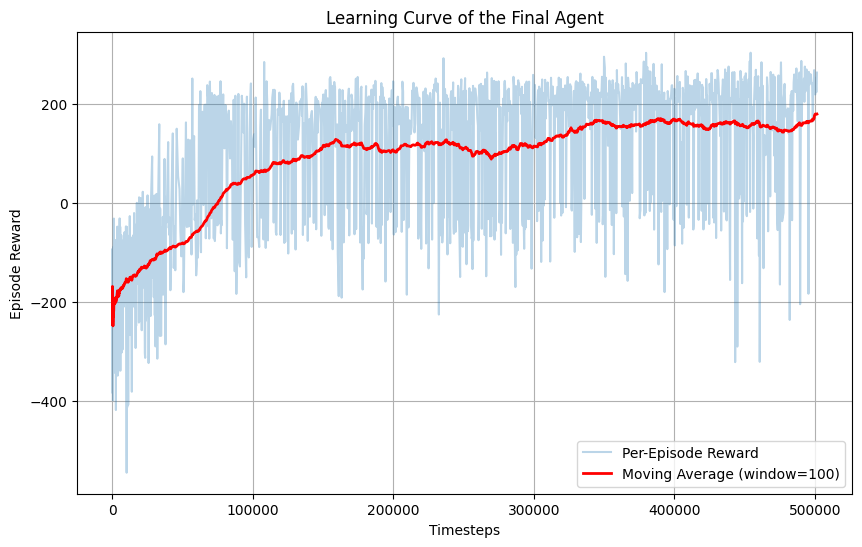

In [ ]:
plot_learning_curve(monitor_file2)
# Round 2: Mean reward after training: 175.96 +/- 102.88
# Träning tog 10min


Här är är en träningskurva från en tisigare träning med PPO, samt dess medelvärde

![alt text](PPO-learn1.png)

#### Mean reward after training: 195.76 +/- 74.14
#### Träningen tog 12 min

Jag valde att inte använda Optuna då jag fick så bra resultat direkt

# OPTUNA

##### DQN är vinnaren för tillfället, men kanske PPO helt enkelt inte hade tillräckligt bra parameterar? Vi testar att använda Optuna för att ta fram de bästa hyperparamterarna för PPO och ser om vi kan vinna över DQN.

##### Koden togs från cart-pole projektet. Nedan finns koden. Under koden finns de vinnande paramterarana som hittades i trial 25/30. 

In [8]:
def objective(trial):
    """The objective function for Optuna to maximize."""
    trial_env3 = gym.make("LunarLander-v3")
    trial_env3 = Monitor(trial_env3)

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    gamma = trial.suggest_float("gamma", 0.9, 0.9999)
    layer_size = trial.suggest_categorical("layer_size", [64, 128, 256])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
    n_epochs = trial.suggest_categorical("n_epochs", [3, 5, 10])
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
    n_steps = trial.suggest_categorical("n_steps", [512, 1024, 2048])
    net_arch = [layer_size, layer_size]
    policy_kwargs = dict(net_arch=net_arch)

    model3 = PPO(
        "MlpPolicy",
        trial_env3,
        learning_rate=learning_rate,
        gamma=gamma,
        batch_size=batch_size,
        policy_kwargs=policy_kwargs,
        gae_lambda=gae_lambda,
        n_epochs=n_epochs,
        clip_range=clip_range,
        n_steps=n_steps
    )

    model3.learn(total_timesteps=5e5)

    mean_reward, _ = evaluate_policy(model3, trial_env3, n_eval_episodes=50)
    trial_env3.close()
    return mean_reward

In [10]:
LOG_DIR = "./logs"  # or any directory you prefer
os.makedirs(LOG_DIR, exist_ok=True)

In [9]:
# Runtime variables
STORAGE_PATH = "sqlite:///my_study.db" # database
STUDY_NAME = "lunar-optimization" # Name of your study
NUM_TRIALS_TO_RUN = 30 # Number of trial runs

study = optuna.create_study(
        direction="maximize",
        study_name=STUDY_NAME,
        storage=STORAGE_PATH,
        load_if_exists=True
    )

# Avoid additional trials | Increase variable for more runs
if len(study.trials) < NUM_TRIALS_TO_RUN:
         study.optimize(objective, n_trials=NUM_TRIALS_TO_RUN - len(study.trials))
else:
         print(f"Study already has {len(study.trials)} trials. Skipping optimization.")

print("\n--- Best Trial Information ---")
best_trial = study.best_trial
if best_trial:
        print(f"  Value (Mean Reward): {best_trial.value:.2f}")
        print("  Params: ")
        for key, value in best_trial.params.items():
                print(f"    {key}: {value}")

        print("\n--- Training the final, best model ---")
        best_params = best_trial.params.copy()
        final_layer_size = best_params.pop('layer_size')
        final_policy_kwargs = dict(net_arch=[final_layer_size, final_layer_size])

        # Create and wrap the environment with Monitor for loggin 
        final_env = gym.make("LunarLander-v3")
        final_log_path = os.path.join(LOG_DIR, "final_model_logs")
        final_env = Monitor(final_env, final_log_path)
                
        final_model = PPO("MlpPolicy", final_env, policy_kwargs=final_policy_kwargs,
                                **best_params, verbose=0)
        final_model.learn(total_timesteps=int(5e5))
        final_model.save("best_lunar_model_PPO")
        print("\nFinal model saved to zip")
                
        # Built-in evaluation
        print("\n--- Evaluating Final Model Performance ---")
        eval_env3 = gym.make("LunarLander-v3")
        eval_env3 = Monitor(eval_env3)
        mean_reward, std_reward = evaluate_policy(final_model, eval_env3, n_eval_episodes=100)
        print(f"Final Model: Mean reward = {mean_reward:.2f} +/- {std_reward:.2f}")
        eval_env3.close()
else:
        print("No successful trials were completed. Cannot train or evaluate a final model.")

[I 2025-10-02 12:58:37,804] Using an existing study with name 'lunar-optimization' instead of creating a new one.
[I 2025-10-02 13:05:35,142] Trial 3 finished with value: -697.7070517000002 and parameters: {'learning_rate': 0.0723525157057281, 'gamma': 0.9049812248956305, 'layer_size': 256, 'batch_size': 32, 'gae_lambda': 0.9724700284302814, 'n_epochs': 3, 'clip_range': 0.25318145542129056, 'n_steps': 1024}. Best is trial 3 with value: -697.7070517000002.
[I 2025-10-02 13:19:17,467] Trial 4 finished with value: -136.27756868 and parameters: {'learning_rate': 0.05465673722408696, 'gamma': 0.9355083535471993, 'layer_size': 256, 'batch_size': 32, 'gae_lambda': 0.9960047616396805, 'n_epochs': 10, 'clip_range': 0.1820504397368004, 'n_steps': 512}. Best is trial 4 with value: -136.27756868.
[I 2025-10-02 13:26:40,133] Trial 5 finished with value: -125.60371396000001 and parameters: {'learning_rate': 0.01310067068561937, 'gamma': 0.9746127881085931, 'layer_size': 256, 'batch_size': 32, 'gae_l


--- Best Trial Information ---
  Value (Mean Reward): -124.88
  Params: 
    learning_rate: 0.05183056215028778
    gamma: 0.9759905745876845
    layer_size: 256
    batch_size: 32
    gae_lambda: 0.8195345417244579
    n_epochs: 5
    clip_range: 0.19286722609813378
    n_steps: 512

--- Training the final, best model ---


NameError: name 'LOG_DIR' is not defined

```
[I 2025-10-02 16:31:24,225] Trial 29 finished with value: -129.1595839 and parameters: {'learning_rate': 0.011080278285381308, 'gamma': 0.9981328592855914, 'layer_size': 256, 'batch_size': 32, 'gae_lambda': 0.9095940576434207, 'n_epochs': 5, 'clip_range': 0.2596765806276585, 'n_steps': 512}. Best is trial 25 with value: -124.87903794000002.

--- Best Trial Information ---
  Value (Mean Reward): -124.88
  Params: 
    learning_rate: 0.05183056215028778
    gamma: 0.9759905745876845
    layer_size: 256
    batch_size: 32
    gae_lambda: 0.8195345417244579
    n_epochs: 5
    clip_range: 0.19286722609813378
    n_steps: 512

--- Training the final, best model ---
``` 

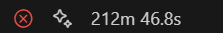

In [11]:
final_log_path = os.path.join(LOG_DIR, "final_model_logs")
final_env = Monitor(final_env, final_log_path)
                
final_model = PPO("MlpPolicy", final_env, policy_kwargs=final_policy_kwargs,
                                **best_params, verbose=0)
final_model.learn(total_timesteps=int(5e5))
final_model.save("best_lunar_model_PPO")
print("\nFinal model saved to zip")
                
# Built-in evaluation
print("\n--- Evaluating Final Model Performance ---")
eval_env3 = gym.make("LunarLander-v3")
eval_env3 = Monitor(eval_env3)
mean_reward, std_reward = evaluate_policy(final_model, eval_env3, n_eval_episodes=100)
print(f"Final Model: Mean reward = {mean_reward:.2f} +/- {std_reward:.2f}")
eval_env3.close()


Final model saved to zip

--- Evaluating Final Model Performance ---
Final Model: Mean reward = -868.30 +/- 577.31



Learning curve plot saved to learning_curve.png


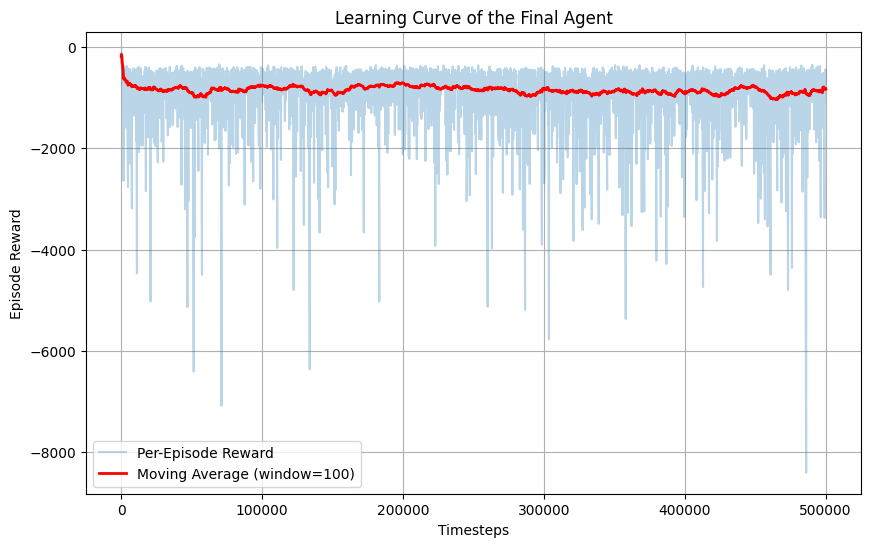

In [14]:
plot_learning_curve(final_log_path)

Detta gick inte alls bra! 
--> Se min analys i rapporten!